## Import Dependencies

In [1]:
import os
import cv2
import shutil
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random

## Dataset Configuration & Validation

In [2]:
# Input Directories
RAW_TRAIN_DIR = '/kaggle/input/facial-emotion-expressions/images/images/train'
RAW_VAL_DIR = '/kaggle/input/facial-emotion-expressions/images/images/validation'

# Output Directories
PROCESSED_ROOT = '/kaggle/working/processed_dataset'
PROCESSED_TRAIN_DIR = os.path.join(PROCESSED_ROOT, 'train')
PROCESSED_VAL_DIR = os.path.join(PROCESSED_ROOT, 'validation')

def check_path(path):
    if os.path.exists(path):
        count = sum([len(files) for r, d, files in os.walk(path)])
        print(f"Found: {path} | Total images: {count}")
        return True
    else:
        print(f"NOT FOUND: {path}")
        return False

print("--- INPUT DATA CHECK ---")
check_train = check_path(RAW_TRAIN_DIR)
check_val = check_path(RAW_VAL_DIR)

if check_train and check_val:
    print("\nPath verification successful. Ready for processing.")
else:
    print("\nPlease verify the dataset paths.")

--- INPUT DATA CHECK ---
Found: /kaggle/input/facial-emotion-expressions/images/images/train | Total images: 28821
Found: /kaggle/input/facial-emotion-expressions/images/images/validation | Total images: 7066

Path verification successful. Ready for processing.


## Image Preprocessing & Augmentation Pipeline

Data balancing target: ~4117 images/class

Processing: /kaggle/input/facial-emotion-expressions/images/images/train -> /kaggle/working/processed_dataset/train


Processing classes:   0%|          | 0/7 [00:00<?, ?it/s]

 -> Class 'angry' needs 124 more images. Generating...
 -> Class 'disgust' needs 3681 more images. Generating...
 -> Class 'fear' needs 14 more images. Generating...
 -> Class 'surprise' needs 912 more images. Generating...
Completed folder: train

Processing: /kaggle/input/facial-emotion-expressions/images/images/validation -> /kaggle/working/processed_dataset/validation


Processing classes:   0%|          | 0/7 [00:00<?, ?it/s]

Completed folder: validation

VISUAL COMPARISON:


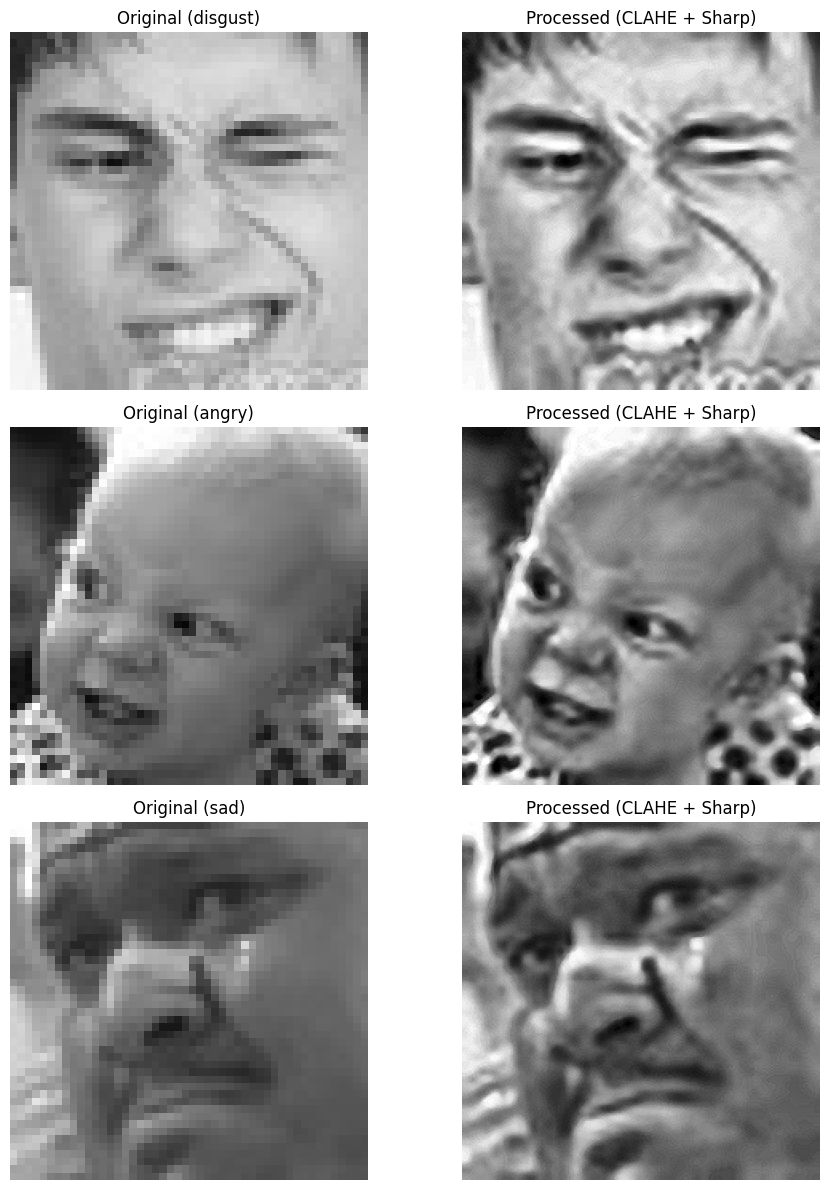

In [3]:
# Configuration
TARGET_SIZE = (224, 224) 

def augment_image(image):
    """
    Applies geometric augmentation (flip, rotate, brightness, contrast).
    """
    augment_type = random.choice(['flip', 'rotate', 'brightness', 'contrast', 'none'])
    
    if augment_type == 'flip':
        return cv2.flip(image, 1) # Horizontal flip
    
    elif augment_type == 'rotate':
        # Slight rotation (+/- 10 degrees) to maintain face orientation
        rows, cols, _ = image.shape
        angle = random.uniform(-10, 10)
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        return cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)
        
    elif augment_type == 'brightness':
        # Adjust Value (V) in HSV color space
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        val = random.randint(-30, 30)
        v = cv2.add(v, val)
        final_hsv = cv2.merge((h, s, v))
        return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

    elif augment_type == 'contrast':
        alpha = random.uniform(0.8, 1.2)
        return cv2.convertScaleAbs(image, alpha=alpha, beta=0)
        
    return image

def process_single_image(img_path, target_size=(224, 224), is_augmentation=False):
    try:
        original_img = cv2.imread(img_path)
        if original_img is None: return None
        
        if is_augmentation:
            original_img = augment_image(original_img)

        # 1. Resize: INTER_AREA for shrinking, INTER_CUBIC for zooming
        h, w = original_img.shape[:2]
        if h > target_size[0]:
            interpolation = cv2.INTER_AREA
        else:
            interpolation = cv2.INTER_CUBIC
        resized_img = cv2.resize(original_img, target_size, interpolation=interpolation)
        
        # 2. Denoise (Bilateral Filter): Preserves edges while smoothing skin
        denoised = cv2.bilateralFilter(resized_img, d=5, sigmaColor=50, sigmaSpace=50)
        
        # 3. CLAHE (Contrast Limited Adaptive Histogram Equalization)
        # Enhances local contrast for better emotion feature detection
        lab = cv2.cvtColor(denoised, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        enhanced_lab = cv2.merge((cl,a,b))
        enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
        
        # 4. Sharpen (Light Unsharp Masking)
        kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
        final_img = cv2.filter2D(enhanced_img, -1, kernel)
        
        return final_img
    except Exception as e:
        return None

def create_balanced_processed_dataset(src_dir, dest_dir, balance_data=True):
    if os.path.exists(dest_dir): shutil.rmtree(dest_dir)
    
    classes = sorted(os.listdir(src_dir))
    
    # Analyze class distribution
    class_counts = {}
    valid_classes = []
    for cls in classes:
        p = os.path.join(src_dir, cls)
        if os.path.isdir(p):
            count = len(os.listdir(p))
            class_counts[cls] = count
            valid_classes.append(cls)
            
    if balance_data:
        target_count = max(int(np.mean(list(class_counts.values()))), 1000)
        print(f"Data balancing target: ~{target_count} images/class")
    
    print(f"\nProcessing: {src_dir} -> {dest_dir}")
    
    for class_name in tqdm(valid_classes, desc="Processing classes"):
        src_class_path = os.path.join(src_dir, class_name)
        dest_class_path = os.path.join(dest_dir, class_name)
        os.makedirs(dest_class_path, exist_ok=True)
        
        files = os.listdir(src_class_path)
        random.shuffle(files) 
        
        processed_count = 0
        
        # Phase 1: Process Original Images
        for file_name in files:
            img_path = os.path.join(src_class_path, file_name)
            processed_img = process_single_image(img_path, target_size=TARGET_SIZE, is_augmentation=False)
            
            if processed_img is not None:
                # Save as PNG to prevent compression artifacts
                save_path = os.path.join(dest_class_path, file_name.replace('.jpg', '.png'))
                cv2.imwrite(save_path, processed_img)
                processed_count += 1
        
        # Phase 2: Augmentation (Upsampling)
        if balance_data and processed_count < target_count:
            diff = target_count - processed_count
            print(f" -> Class '{class_name}' needs {diff} more images. Generating...")
            
            src_files_pool = files.copy()
            for i in range(diff):
                if not src_files_pool: break
                
                random_file = random.choice(src_files_pool)
                img_path = os.path.join(src_class_path, random_file)
                
                aug_img = process_single_image(img_path, target_size=TARGET_SIZE, is_augmentation=True)
                
                if aug_img is not None:
                    save_name = f"aug_{i}_{random_file.replace('.jpg', '.png')}"
                    cv2.imwrite(os.path.join(dest_class_path, save_name), aug_img)

    print(f"Completed folder: {os.path.basename(dest_dir)}")

def visualize_comparison(raw_dir, processed_dir, num_samples=3):
    classes = os.listdir(raw_dir)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples*4))
    
    for i in range(num_samples):
        cls = random.choice(classes)
        raw_cls_path = os.path.join(raw_dir, cls)
        processed_cls_path = os.path.join(processed_dir, cls)
        
        fname = random.choice(os.listdir(raw_cls_path))
        fname_processed = fname.replace('.jpg', '.png')
        
        if not os.path.exists(os.path.join(processed_cls_path, fname_processed)):
            continue
            
        img_raw = cv2.cvtColor(cv2.imread(os.path.join(raw_cls_path, fname)), cv2.COLOR_BGR2RGB)
        img_proc = cv2.cvtColor(cv2.imread(os.path.join(processed_cls_path, fname_processed)), cv2.COLOR_BGR2RGB)
        
        axes[i, 0].imshow(img_raw)
        axes[i, 0].set_title(f"Original ({cls})")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img_proc)
        axes[i, 1].set_title(f"Processed (CLAHE + Sharp)")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Execution
create_balanced_processed_dataset(RAW_TRAIN_DIR, PROCESSED_TRAIN_DIR, balance_data=True)
create_balanced_processed_dataset(RAW_VAL_DIR, PROCESSED_VAL_DIR, balance_data=False)

print("\nVISUAL COMPARISON:")
visualize_comparison(RAW_TRAIN_DIR, PROCESSED_TRAIN_DIR)

## Export Processed Dataset

In [4]:
print("Compressing dataset into ZIP file...")
shutil.make_archive('/kaggle/working/processed_dataset_final', 'zip', PROCESSED_ROOT)

Compressing dataset into ZIP file...


'/kaggle/working/processed_dataset_final.zip'